In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [73]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "kd_reg_e2.pth"
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)

In [74]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

class LeNet(Module):
    def __init__(self, numChannels, classes):
        super(LeNet, self).__init__()

        # CONV => RELU => POOL
        self.conv1 = Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5,5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2,2), stride=(2,2))

        # second set of CONV layers
        self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5,5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2,2), stride=(2,2))

        # FC layer
        self.fc1 = Linear(in_features=800, out_features=500)
        self.relu3 = ReLU()

        # softmax
        self.fc2 = Linear(in_features=500, out_features=classes)
        self.logSoftmax = LogSoftmax(dim=1)

    def forward(self, x):
        hidden_states = []
        
        # pass the input through our first set of CONV => RELU =>
        # POOL layers
        x = self.conv1(x)
        hidden_states.append(x.clone())
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv2(x)
        hidden_states.append(x.clone())
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        # flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers
        x = flatten(x, 1)
        x = self.fc1(x)
        hidden_states.append(x.clone())
        x = self.relu3(x)
        
        # pass the output to our softmax classifier to get our output
        # predictions
        x = self.fc2(x)
        output = self.logSoftmax(x)
        
        # return the output predictions
        return output, hidden_states
    

In [75]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='evaldata', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

# Initialize the network
model = LeNet(numChannels=1, classes=10).to(device)

# Load the pretrained model
model = torch.load(pretrained_model, map_location=device)

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

In [76]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [77]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output, hs = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output, hs = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [78]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9424 / 10000 = 0.9424
Epsilon: 0.05	Test Accuracy = 8624 / 10000 = 0.8624
Epsilon: 0.1	Test Accuracy = 7765 / 10000 = 0.7765
Epsilon: 0.15	Test Accuracy = 6624 / 10000 = 0.6624
Epsilon: 0.2	Test Accuracy = 5502 / 10000 = 0.5502
Epsilon: 0.25	Test Accuracy = 4459 / 10000 = 0.4459
Epsilon: 0.3	Test Accuracy = 3615 / 10000 = 0.3615


In [79]:
%matplotlib inline

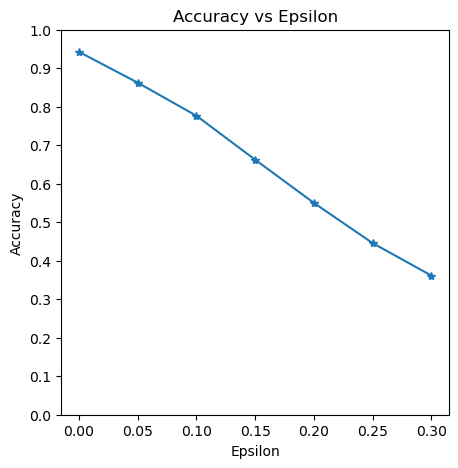

In [80]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.savefig('kd_reg_e2_acc_vs_ep.pdf')
plt.show()

In [81]:
accuracies_kd_e2 = accuracies

In [68]:
accuracies_no = accuracies

In [58]:
accuracies_kd = accuracies

## Results

With regularization:

Epsilon: 0	Test Accuracy = 9902 / 10000 = 0.9902
Epsilon: 0.05	Test Accuracy = 9547 / 10000 = 0.9547
Epsilon: 0.1	Test Accuracy = 8792 / 10000 = 0.8792
Epsilon: 0.15	Test Accuracy = 7383 / 10000 = 0.7383
Epsilon: 0.2	Test Accuracy = 5407 / 10000 = 0.5407
Epsilon: 0.25	Test Accuracy = 3580 / 10000 = 0.358
Epsilon: 0.3	Test Accuracy = 2324 / 10000 = 0.2324

Without regularization:
Epsilon: 0	Test Accuracy = 9870 / 10000 = 0.987
Epsilon: 0.05	Test Accuracy = 9345 / 10000 = 0.9345
Epsilon: 0.1	Test Accuracy = 8067 / 10000 = 0.8067
Epsilon: 0.15	Test Accuracy = 6132 / 10000 = 0.6132
Epsilon: 0.2	Test Accuracy = 4299 / 10000 = 0.4299
Epsilon: 0.25	Test Accuracy = 2918 / 10000 = 0.2918
Epsilon: 0.3	Test Accuracy = 2055 / 10000 = 0.2055

With regularization 1e-2:
Epsilon: 0	Test Accuracy = 9424 / 10000 = 0.9424
Epsilon: 0.05	Test Accuracy = 8624 / 10000 = 0.8624
Epsilon: 0.1	Test Accuracy = 7765 / 10000 = 0.7765
Epsilon: 0.15	Test Accuracy = 6624 / 10000 = 0.6624
Epsilon: 0.2	Test Accuracy = 5502 / 10000 = 0.5502
Epsilon: 0.25	Test Accuracy = 4459 / 10000 = 0.4459
Epsilon: 0.3	Test Accuracy = 3615 / 10000 = 0.3615

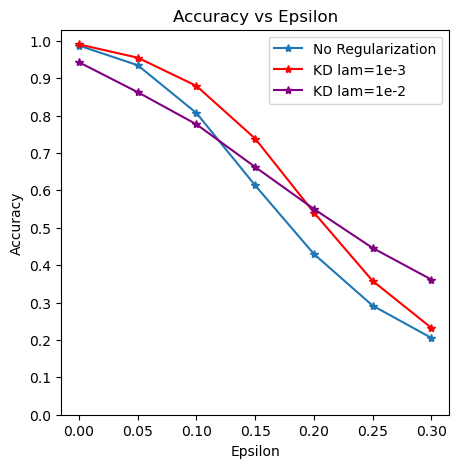

In [83]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_no, "*-", label='No Regularization')
plt.plot(epsilons, accuracies_kd, "*-", color='red', label='KD lam=1e-3')
plt.plot(epsilons, accuracies_kd_e2, "*-", color='purple', label='KD lam=1e-2')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('all_vs_ep.pdf')
plt.show()

In [1]:
import torch

print("CUDA Available: ",torch.cuda.is_available())

CUDA Available:  True


In [2]:
torch.version.cuda

'11.7'

In [3]:
torch.__version__

'2.0.0+cu117'

In [4]:
!which python

/home/kenneth/anaconda3/envs/cv/bin/python
